In [13]:
import numpy as np
import h5py
import os

# Data
tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
results_dir = './outputs/'

def read_results(filename):
    signal_magnitude = []       
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])     
        S = np.array(h5['scales'])  
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, :, :]                           
            M_f = np.mean(M_f[...,0:2], axis=0)        
            signal_magnitude.append(np.linalg.norm(M_f, axis=-1))   
    return signal_magnitude

############
radius = 8
oxy_level = [78, 85]
orientation = 90
mixing_time = [40, 80, 200, 500, 1000]
signal_change_ste =[]
signal_change_klaus_ste =[]
for m in mixing_time:
    signal_magnitude = []
    for o in oxy_level:
        filename = f'ste_{o}_mix{m}_r{radius}_Y0.0_BVF{4}_ori{orientation}_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)    
    signal_change_ste.append( 100 * (1 - signal_magnitude[0,...] / signal_magnitude[1,...]))
    signal_change_klaus_ste.append(signal_magnitude[1,...] - signal_magnitude[0,...])

with h5py.File(os.path.join(results_dir, f'{filename}.h5'), 'r') as h5:
    scales = np.array(h5['scales']).squeeze()

# save as mat file
import scipy.io as sio
sio.savemat(os.path.join(results_dir, 'signal_change_ste.mat'), {'radius':radius, 'scales':scales, 'signal_change_klaus_ste':signal_change_klaus_ste, 'signal_change_ste': signal_change_ste, 'mixing_time':mixing_time})


(2, 50, 2)
(2, 50, 2)
(2, 50, 2)
(2, 50, 2)
(2, 50, 2)


In [14]:
# load mat file
import os
import numpy as np
import scipy.io as sio
results_dir = './outputs/'
data = sio.loadmat(os.path.join(results_dir, 'signal_change_ste.mat'))
signal_change_ste  = np.array(data['signal_change_ste'])
signal_change_klaus_ste  = np.array(data['signal_change_klaus_ste'])

scales = data['scales']
radius = data['radius']
mixing_time = data['mixing_time'].reshape(-1)

print(signal_change_ste.shape, mixing_time)


(5, 50, 2) [  40   80  200  500 1000]


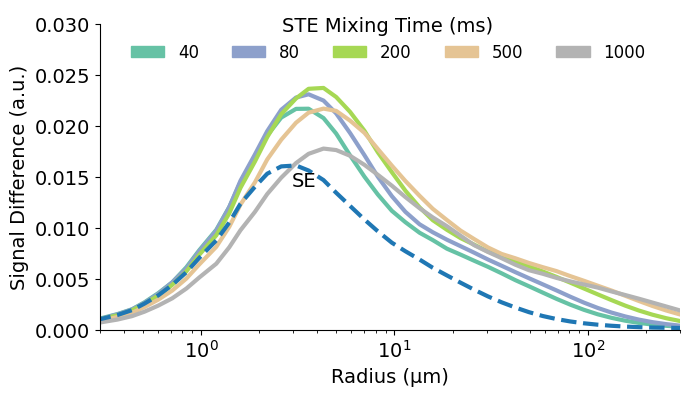

In [15]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

plt.close('all')
cmap = plt.get_cmap('Set2')
colors = cmap(np.linspace(0, 1, len(signal_change_klaus_ste)))

x = radius * scales.squeeze()
x = x.reshape(-1)
x = np.where(x < 1, np.round(x, 2), np.round(x, 1))
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
for i, (m, s, color) in enumerate(zip(mixing_time, signal_change_klaus_ste, colors)):
    ax.plot(x, s[:,-1], color=color, label=f'{m}', linewidth=3)

ax.plot(x, np.squeeze(signal_change_klaus_ste[0, :, 0]), '--', label=f'SE', linewidth=3)

ax.set_xlabel('Radius (µm)', fontsize=14)
ax.set_ylabel('Signal Difference (a.u.)', fontsize=14)
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
ax.set_xlim([0.3, 300])
# ax.set_ylim([0., 24])
ax.set_ylim([0., 0.03])

ax.patch.set_visible(False)
ax.text(0.33, 0.47, 'SE', transform=ax.transAxes, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

patches = [mpatches.Patch(color=c, label=f'{b}') for (c, b) in zip(colors, mixing_time)]
fig.legend(handles=patches, title='STE Mixing Time (ms)', bbox_to_anchor=(.95, 1.), ncols=5, frameon=False,  fontsize=12, title_fontsize=14)

# fig.patch.set_visible(False)
fig.tight_layout()
# plt.savefig('./figures/ste.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig('../figures_pdf/ste.pdf', format='pdf', dpi=1200, bbox_inches='tight')

plt.show()